In [1]:
%load_ext sppl.magics
%matplotlib inline
import matplotlib.pyplot as plt

### The ClickGraph model

[ClickGraph](https://dotnet.github.io/infer/userguide/Click%20model%20example.html) is an information-retrieval model used to compute the posterior probability that a pair of items A and B are similar, conditioned on a user's access patterns to these items.  This model is used, for example, to measure the quality of a search engine, where A and B represent two URLs that are returned to a given search query.  A search engine is said to be good if the probability that URLs A and B are similar is high.

The probabilistic program below implements the ClickGraph model, for five pairs of URLs and one user's click patterns.

In [2]:
%%sppl model
from sppl.sym_util import binspace

p_similar ~= beta(a=1, b=1)   # Prior probabilty URLs A and B are similar. (in [0,1])

# Five file pairs
similar         = array(5)    # Are url_A[i] and url_B[i] similar? (binary)
p_click_url_A   = array(5)    # Probability user clicks url_A[i]. (in [0,1])
p_click_url_B   = array(5)    # Probability user clicks url_B[i]. (in [0,1])
click_url_A     = array(5)    # Did user click url_A[i]? (binary)
click_url_B     = array(5)    # Did user click url_B[i]? (binary)

for i in range(5):
    switch (p_similar) cases (p in binspace(0, 1, 20)):
        similar[i] ~= bernoulli(p=p.right)

    if similar[i] == 1:
        p_click_url_A[i] ~= uniform()
        p_click_url_B[i] ~= p_click_url_A[i]
    else:
        p_click_url_A[i] ~= uniform()
        p_click_url_B[i] ~= uniform()

    switch (p_click_url_A[i]) cases (p in binspace(0, 1, 10)):
        click_url_A[i] ~= bernoulli(p=p.right)

    switch (p_click_url_B[i]) cases (p in binspace(0, 1, 10)):
        click_url_B[i] ~= bernoulli(p=p.right)

In [3]:
n = %sppl_get_namespace model

We next record observations of the users clicks for each of the 10 URLs. Using `model.condition` returns a new model, called `modelc`, which represents the exact posterior distribution of all random variables in the program.

In [4]:
observations = (
        n.click_url_A[0] << {1} & n.click_url_A[0] << {1}
    &   n.click_url_A[1] << {1} & n.click_url_B[1] << {1}
    &   n.click_url_A[2] << {0} & n.click_url_B[2] << {0}
    &   n.click_url_A[3] << {1} & n.click_url_B[3] << {1}
    &   n.click_url_A[4] << {0} & n.click_url_B[4] << {0})

In [5]:
modelc = n.model.condition(observations)

We next compute the prior and posterior distributions of `p_similar` for plotting.

In [6]:
import numpy as np
xs = np.linspace(0, 1, 30)
cdf_prior = [n.model.prob(n.p_similar < x) for x in xs]
cdf_posterior = [modelc.prob(n.p_similar < x) for x in xs]

pdf_prior = np.exp([n.model.logpdf(n.p_similar << {x}) for x in xs])
pdf_posterior = np.exp([modelc.logpdf(n.p_similar << {x}) for x in xs])

samples_prior = n.model.sample_subset([n.p_similar], N=4000)
samples_posterior = modelc.sample_subset([n.p_similar], N=4000)

The posterior of `p_similar` has shifted from the uniform prior (black) to a posterior left-skewed distribution (red), based on the observed clicks.

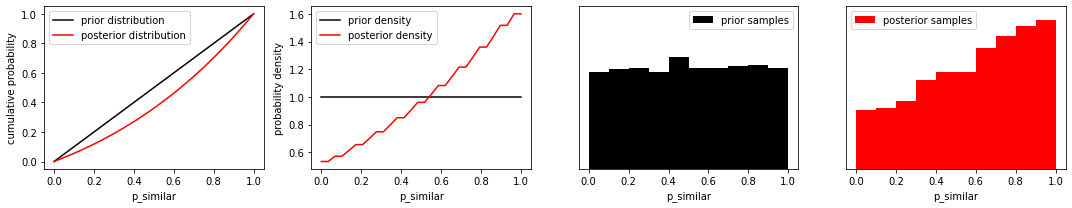

In [7]:
fig, axes = plt.subplots(ncols=4)

axes[0].plot(xs, cdf_prior, color='k', label='prior distribution')
axes[0].plot(xs, cdf_posterior, color='r', label='posterior distribution')
axes[0].set_xlabel('p_similar')
axes[0].set_ylabel('cumulative probability')
axes[0].legend(loc='upper left')

axes[1].plot(xs, pdf_prior, color='k', label='prior density')
axes[1].plot(xs, pdf_posterior, color='r', label='posterior density')
axes[1].set_xlabel('p_similar')
axes[1].set_ylabel('probability density')
axes[1].legend(loc='upper left')

axes[2].hist([s[n.p_similar] for s in samples_prior],
    bins=10, density=1, color='k', label='prior samples');
axes[3].hist([s[n.p_similar] for s in samples_posterior],
    bins=10, density=1, color='r', label='posterior samples');
for ax in axes[2:]:
    ax.set_ylim([0, 1.6])
    ax.set_yticks([])
    ax.set_xlabel('p_similar')
    ax.legend()

fig.set_size_inches(15, 3)
fig.set_tight_layout(True)